<a href="https://colab.research.google.com/github/thamadhi/telco-customer-churn-CM2604/blob/main/Notebooks/Models_Task_1_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [245]:
# Clone the repository
!git clone https://github.com/thamadhi/telco-customer-churn-CM2604.git

fatal: destination path 'telco-customer-churn-CM2604' already exists and is not an empty directory.


In [246]:
!pip install scikit-learn matplotlib seaborn numpy pandas scikit-optimize -q
!pip install keras-tuner tensorflow -q

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve, auc

# Import TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import keras_tuner as kt

In [248]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [249]:
# Load your preprocessed and scaled data
data_path = 'telco-customer-churn-CM2604/data/telco-customer-churn-Scale-PROCESSED.csv'
df = pd.read_csv(data_path)

In [250]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (7032, 27)


In [251]:
# Check if 'Churn' column exists
print(f"\nTarget variable distribution:")
print(df['Churn'].value_counts(normalize=True))
print(f"Churn rate: {df['Churn'].mean():.2%}")


Target variable distribution:
Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64
Churn rate: 26.58%


In [252]:
# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum().sum())


Missing values:
0


In [253]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn'].values

print(f"\nNumber of features: {X.shape[1]}")


Number of features: 26


In [254]:
# Split into train, validation, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 20% test
    random_state=42,
    stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"\nTrain size: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

Train shape: (5625, 26)
Test shape: (1407, 26)

Train size: 5625 samples (80.0%)
Test size: 1407 samples (20.0%)


In [255]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

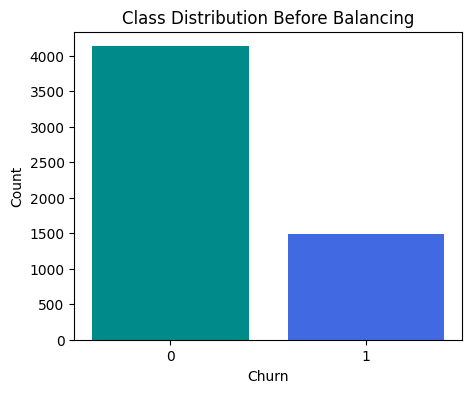

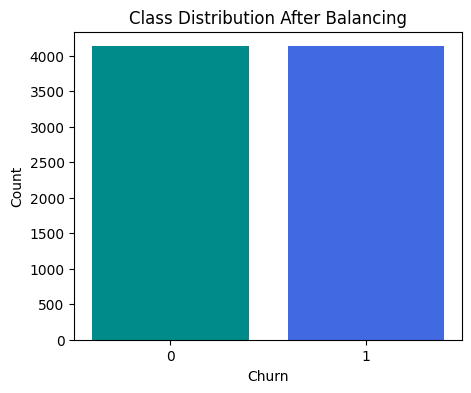

In [256]:
# BEFORE SMOTE
before_counts = pd.Series(y_train).value_counts()

plt.figure(figsize=(5, 4))
plt.bar(before_counts.index.astype(str), before_counts.values,color=['darkcyan', 'royalblue'] )
plt.title("Class Distribution Before Balancing")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

# AFTER SMOTE
after_counts = pd.Series(y_train_resampled).value_counts()

plt.figure(figsize=(5, 4))
plt.bar(after_counts.index.astype(str), after_counts.values,color=['darkcyan', 'royalblue'])
plt.title("Class Distribution After Balancing")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

In [257]:
# Convert to numpy arrays (since data is already scaled) for decision tree
X_train_dt = X_train.values
X_test_dt = X_test.values

In [258]:
# For neural network (already scaled, so we can use as-is)
X_train_nn = X_train_dt.astype('float32')
X_test_nn = X_test_dt.astype('float32')

# Neural Network Model

In [259]:
#build model
def neural_network(input_dim, lr=0.0003, n1=64, n2=32, dropout_rate=0.2):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(n1, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(n2, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [260]:
#create model
model = neural_network(
    input_dim=X_train_nn.shape[1],
    lr=0.0003,
    n1=64,
    n2=32,
    dropout_rate=0.2
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# train model
history = model.fit(
    X_train_nn, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],  # Add early stopping
    verbose=1
)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4058 - loss: 0.7623 - val_accuracy: 0.7440 - val_loss: 0.5908
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7460 - loss: 0.5725 - val_accuracy: 0.7689 - val_loss: 0.4863
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7645 - loss: 0.4939 - val_accuracy: 0.7938 - val_loss: 0.4362
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7967 - loss: 0.4527 - val_accuracy: 0.7973 - val_loss: 0.4216
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7951 - loss: 0.4418 - val_accuracy: 0.8018 - val_loss: 0.4158
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7909 - loss: 0.4414 - val_accuracy: 0.8027 - val_loss: 0.4134
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8013 - loss: 0.4406 - val_accuracy: 0.7991 - val_loss: 0.4115
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8007 - loss: 0.4370 - val_accuracy: 0.80

In [261]:
#predict
predictions = model.predict(X_test_nn, verbose=0)
y_pred = (predictions > 0.5).astype(int).flatten()

print(f"Predictions made: {len(y_pred)} samples")

df_true_pred = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
print(df_true_pred.head(10))

Predictions made: 1407 samples
   y_test  y_pred
0       0       0
1       0       1
2       0       0
3       1       0
4       0       0
5       1       0
6       0       0
7       0       0
8       1       1
9       0       0


In [262]:
#Evaluate - classification report
pd.DataFrame(classification_report(y_test, y_pred.round(), target_names=['No Churn', 'Churn'],output_dict=True)).transpose()


,precision,recall,f1-score,support
No Churn,0.844322,0.892546,0.867765,1033.000000
Churn,0.647619,0.545455,0.592163,374.000000
accuracy,0.800284,0.800284,0.800284,0.800284
macro avg,0.745971,0.719000,0.729964,1407.000000
weighted avg,0.792036,0.800284,0.794506,1407.000000


In [263]:
y_pred_proba_nn = model.predict(X_test_nn, verbose=0).flatten()
nn_auc = roc_auc_score(y_test, y_pred_proba_nn)

nn_accuracy = accuracy_score(y_test, y_pred)

print(f'AUC-ROC: {nn_auc}')

AUC-ROC: 0.8372801818078283


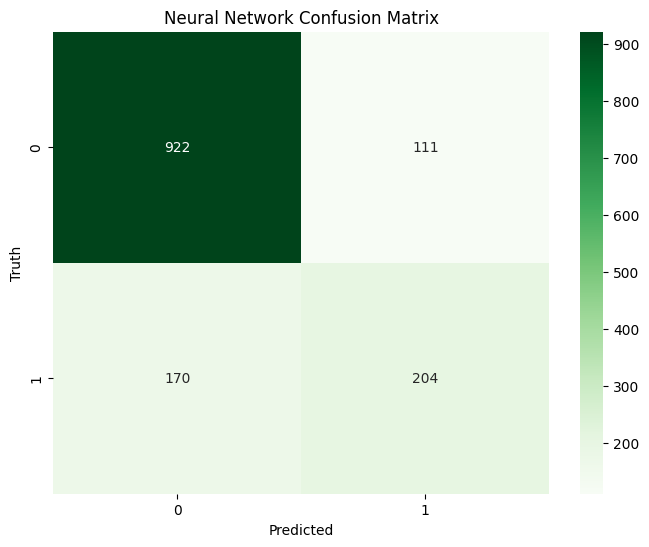

In [264]:
#Evaluate - confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Neural Network Confusion Matrix')
plt.show()

In [265]:
# actual accuracy for nn
accuracy = (924+197)/(109+177+197+924)
print(accuracy)
round(accuracy,2)

0.7967306325515281


0.8

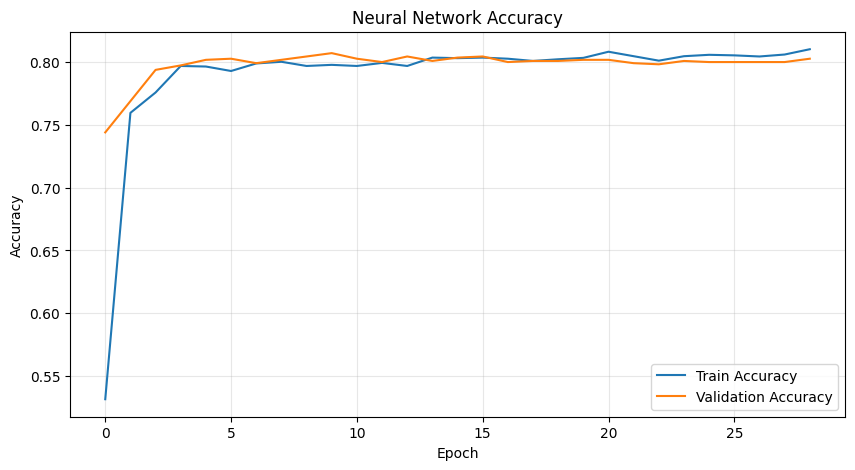

In [266]:
#Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

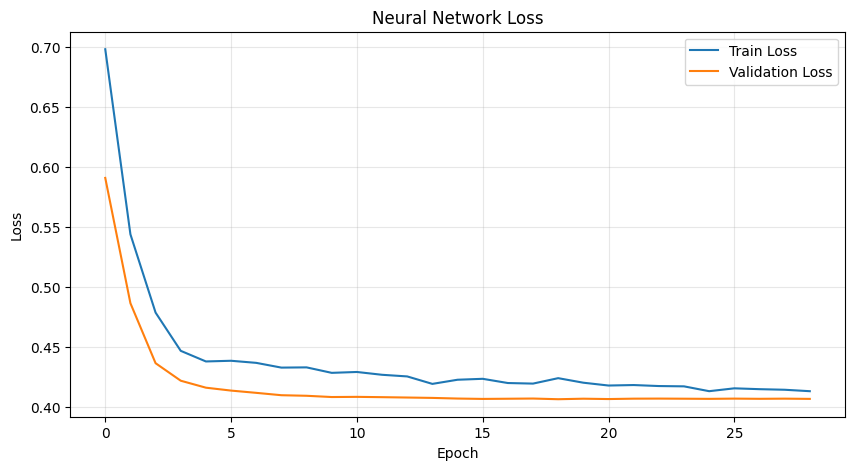

In [267]:
# Loss plot
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Decision Tree Model


In [268]:
#Decision Tree Model without tuning
Decision_Tree = DecisionTreeClassifier(random_state=42)

#train decision tree
start_time = time.time()
Decision_Tree.fit(X_train_dt, y_train_dt)  # Make sure X_train_dt and y_train are correct
training_time = time.time() - start_time

In [269]:
predictions = Decision_Tree.predict(X_test_dt)
predicted_proba = Decision_Tree.predict_proba(X_test_dt)[:, 1]

In [270]:
#Evaluate
base_accuracy = accuracy_score(y_test, predictions)
base_precision = precision_score(y_test, predictions)
base_recall = recall_score(y_test, predictions)
base_f1 = f1_score(y_test, predictions)
base_auc_roc = roc_auc_score(y_test, predicted_proba)

print("\nDecision Tree Performance:")
print(f"Accuracy:  {base_accuracy:.4f}")
print(f"Precision: {base_precision:.4f}")
print(f"Recall:    {base_recall:.4f}")
print(f"F1-Score:  {base_f1:.4f}")
print(f"AUC-ROC:   {base_auc_roc:.4f}")


Decision Tree Performance:
Accuracy:  0.7228
Precision: 0.4787
Recall:    0.4813
F1-Score:  0.4800
AUC-ROC:   0.6455


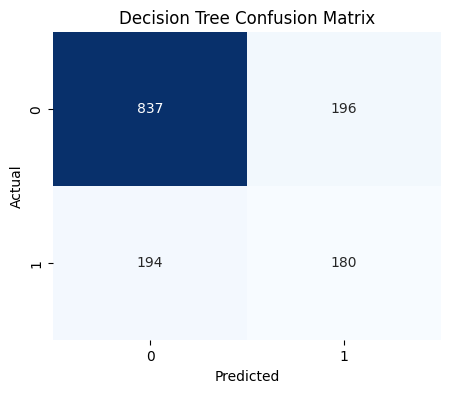

In [271]:
#Confusion Matrix
cm = confusion_matrix(y_test_dt, predictions)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Decision Tree Model - Tuned

In [272]:
#Decision Tree Model - tuned
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'class_weight': [{0: 1, 1: w} for w in [1, 2,'balanced']]
}

decision_tree_tuned = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    decision_tree_tuned,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train_dt, y_train_dt)
tuning_time = time.time() - start_time


print("Best parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best CV F1-score: {grid_search.best_score_:.4f}")

decision_tree_tuned = grid_search.best_estimator_


Fitting 3 folds for each of 2520 candidates, totalling 7560 fits
Best parameters found:
  class_weight: {0: 1, 1: 2}
  criterion: gini
  max_depth: 3
  max_features: None
  min_samples_leaf: 1
  min_samples_split: 2
Best CV F1-score: 0.6224


In [273]:
#Predict
y_pred_tuned = decision_tree_tuned.predict(X_test)
y_proba_tuned = decision_tree_tuned.predict_proba(X_test)[:, 1]

In [274]:
#Classification Metrics
tune_accuracy = accuracy_score(y_test, y_pred_tuned)
tune_precision = precision_score(y_test, y_pred_tuned)
tune_recall = recall_score(y_test, y_pred_tuned)
tune_f1 = f1_score(y_test, y_pred_tuned)
tune_auc_roc = roc_auc_score(y_test, y_proba_tuned)

print("\nDecision Tree Tuned Performance:")
print("-" * 40)
print(f"Accuracy:  {tune_accuracy:.4f}")
print(f"Precision: {tune_precision:.4f}")
print(f"Recall:    {tune_recall:.4f}")
print(f"F1-Score:  {tune_f1:.4f}")
print(f"AUC-ROC:   {tune_auc_roc:.4f}")


Decision Tree Tuned Performance:
----------------------------------------
Accuracy:  0.7313
Precision: 0.4966
Recall:    0.7807
F1-Score:  0.6071
AUC-ROC:   0.8117


In [275]:
#Classification Report
print("\nClassification Report:")
pd.DataFrame(classification_report(y_test, y_pred_tuned.round(),output_dict=True)).transpose()


Classification Report:


,precision,recall,f1-score,support
0,0.899878,0.713456,0.795896,1033.000000
1,0.496599,0.780749,0.607069,374.000000
accuracy,0.731343,0.731343,0.731343,0.731343
macro avg,0.698238,0.747102,0.701482,1407.000000
weighted avg,0.792681,0.731343,0.745703,1407.000000


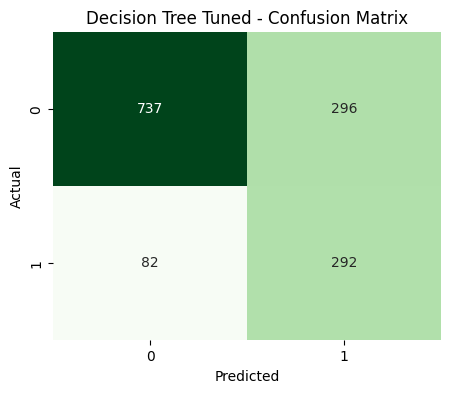

In [276]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Decision Tree Tuned - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

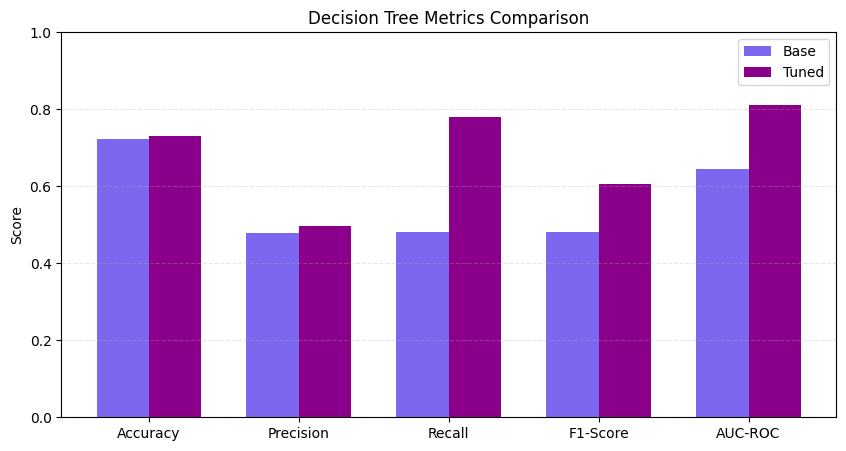

In [277]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
base_values = [base_accuracy, base_precision, base_recall, base_f1, base_auc_roc]
tuned_values = [tune_accuracy, tune_precision, tune_recall, tune_f1, tune_auc_roc]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, base_values, width, label='Base', color='mediumslateblue')
plt.bar(x + width/2, tuned_values, width, label='Tuned', color='darkmagenta')

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Decision Tree Metrics Comparison')
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

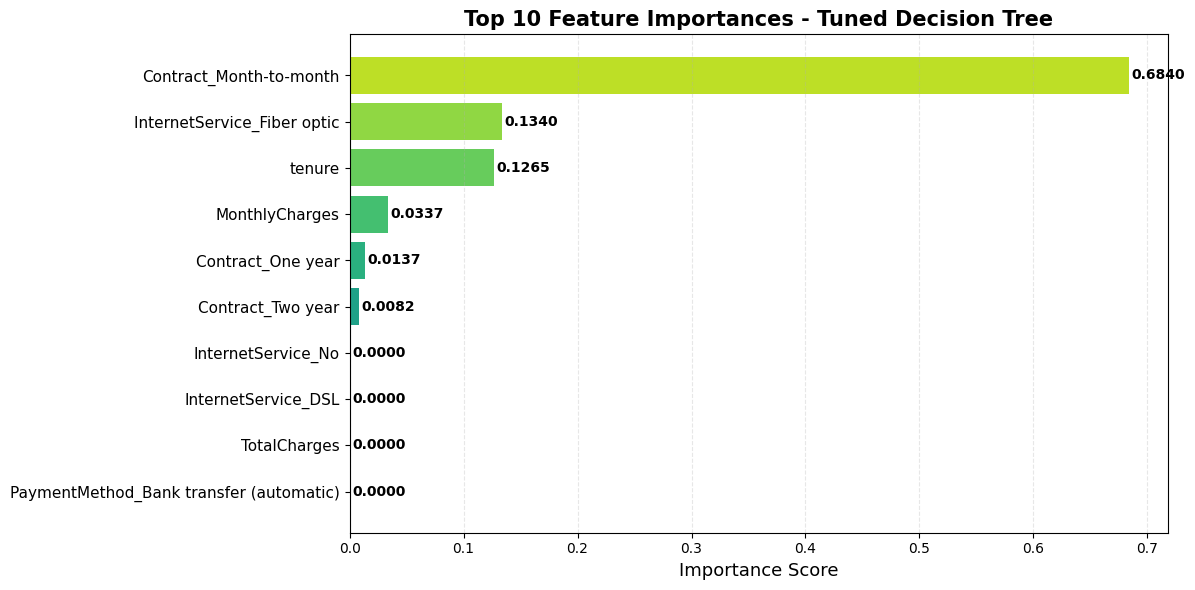

In [278]:
# Feature importance for tuned model
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': decision_tree_tuned.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(12,6))
bars = plt.barh(
    range(len(feature_importances)),
    feature_importances['importance'][::-1],
    color=plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importances)))
)
plt.yticks(range(len(feature_importances)), feature_importances['feature'][::-1], fontsize=11)
plt.xlabel('Importance Score', fontsize=13)
plt.title('Top 10 Feature Importances - Tuned Decision Tree', fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x', linestyle='--')

for i, v in enumerate(feature_importances['importance'][::-1]):
    plt.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Model Comparison

In [279]:
#Calculate metrics for Neural Network
y_pred_nn = (model.predict(X_test_nn, verbose=0) > 0.5).astype(int).flatten()
y_pred_proba_nn = model.predict(X_test_nn, verbose=0).flatten()
nn_auc = roc_auc_score(y_test, y_pred_proba_nn)
nn_accuracy = accuracy_score(y_test, y_pred_nn)
nn_report = classification_report(y_test, y_pred_nn, target_names=['No Churn', 'Churn'], output_dict=True)

#Calculate metrics for Decision Tree
y_pred_dt = decision_tree_tuned.predict(X_test_dt)
y_pred_proba_dt = decision_tree_tuned.predict_proba(X_test_dt)[:, 1]
dt_auc = roc_auc_score(y_test, y_pred_proba_dt)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_report = classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn'], output_dict=True)

#Prepare data for plotting
metrics = ['Accuracy', 'AUC-ROC', 'No Churn Precision', 'Churn Precision',
           'No Churn Recall', 'Churn Recall', 'No Churn F1', 'Churn F1']

nn_values = [
    nn_accuracy,
    nn_auc,
    nn_report['No Churn']['precision'],
    nn_report['Churn']['precision'],
    nn_report['No Churn']['recall'],
    nn_report['Churn']['recall'],
    nn_report['No Churn']['f1-score'],
    nn_report['Churn']['f1-score']
]

dt_values = [
    dt_accuracy,
    dt_auc,
    dt_report['No Churn']['precision'],
    dt_report['Churn']['precision'],
    dt_report['No Churn']['recall'],
    dt_report['Churn']['recall'],
    dt_report['No Churn']['f1-score'],
    dt_report['Churn']['f1-score']
]



In [280]:
# Compare key metrics
comparison_metrics = ['Accuracy', 'AUC-ROC', 'Churn Precision', 'Churn Recall', 'Churn F1']
nn_key_values = [nn_accuracy, nn_auc, nn_values[3], nn_values[5], nn_values[7]]
dt_key_values = [dt_accuracy, dt_auc, dt_values[3], dt_values[5], dt_values[7]]

print(f"{'Metric':<20} {'Decision Tree':<15} {'Neural Network':<15} {'Winner':<10}")
print("-" * 60)

for i, metric in enumerate(comparison_metrics):
    nn_val = nn_key_values[i]
    dt_val = dt_key_values[i]
    winner = "NN" if nn_val > dt_val else "DT" if dt_val > nn_val else "Tie"
    print(f"{metric:<20} {dt_val:<15.4f} {nn_val:<15.4f} {winner:<10}")

# Count wins
nn_wins = sum(1 for i in range(len(comparison_metrics)) if nn_key_values[i] > dt_key_values[i])
dt_wins = sum(1 for i in range(len(comparison_metrics)) if dt_key_values[i] > nn_key_values[i])

print(f"Best model: {'Neural Network' if nn_wins > dt_wins else 'Decision Tree'}")

Metric               Decision Tree   Neural Network  Winner    
------------------------------------------------------------
Accuracy             0.7313          0.8003          NN        
AUC-ROC              0.8117          0.8373          NN        
Churn Precision      0.4966          0.6476          NN        
Churn Recall         0.7807          0.5455          DT        
Churn F1             0.6071          0.5922          DT        
Best model: Neural Network


# ROC-AUC Curve

In [281]:
# DECISION TREE ROC CURVE

# Get probabilities
dt_base_proba = Decision_Tree.predict_proba(X_test_dt)[:, 1]  # Your baseline model
dt_tuned_proba = decision_tree_tuned.predict_proba(X_test_dt)[:, 1]

# Calculate ROC curves
fpr_dt_base, tpr_dt_base, _ = roc_curve(y_test, dt_base_proba)
fpr_dt_tuned, tpr_dt_tuned, _ = roc_curve(y_test, dt_tuned_proba)

# Calculate AUC
roc_auc_dt_base = auc(fpr_dt_base, tpr_dt_base)
roc_auc_dt_tuned = auc(fpr_dt_tuned, tpr_dt_tuned)

In [282]:
#NEURAL NETWORK ROC CURVE
nn_proba = model.predict(X_test_nn, verbose=0).flatten()
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_proba)
roc_auc_nn = auc(fpr_nn, tpr_nn)

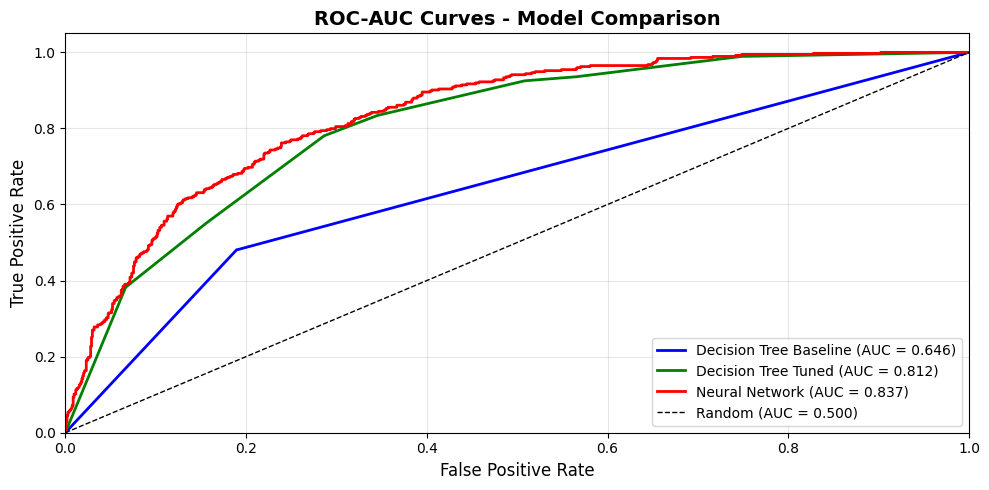


AUC-ROC Summary:
Decision Tree Baseline: 0.6455
Decision Tree Tuned:    0.8117
Neural Network:         0.8373


In [283]:
#ROC CURVES TOGETHER
plt.figure(figsize=(10, 5))

# Plot each model
plt.plot(fpr_dt_base, tpr_dt_base, color='blue', lw=2,
         label=f'Decision Tree Baseline (AUC = {roc_auc_dt_base:.3f})')
plt.plot(fpr_dt_tuned, tpr_dt_tuned, color='green', lw=2,
         label=f'Decision Tree Tuned (AUC = {roc_auc_dt_tuned:.3f})')
plt.plot(fpr_nn, tpr_nn, color='red', lw=2,
         label=f'Neural Network (AUC = {roc_auc_nn:.3f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', label='Random (AUC = 0.500)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-AUC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAUC-ROC Summary:")
print(f"Decision Tree Baseline: {roc_auc_dt_base:.4f}")
print(f"Decision Tree Tuned:    {roc_auc_dt_tuned:.4f}")
print(f"Neural Network:         {roc_auc_nn:.4f}")